# Libraries

In [819]:
# import csv
# import os
import re
import json
import umap

import hdbscan
import numpy as np
import pandas as pd


import matplotlib.pyplot as plt
import matplotlib.colors
from IPython.display import clear_output
from pointgrid import align_points_to_grid

from sklearn import preprocessing
from sklearn.linear_model import LinearRegression
from sklearn.preprocessing import MinMaxScaler
from sklearn.feature_extraction.text import CountVectorizer
from sklearn.feature_extraction.text import TfidfTransformer

# import math
import matplotlib.pyplot as plt
from scipy.spatial import ConvexHull
from scipy import interpolate


# Import

## Dataset

In [820]:
# query = "Query_NYT_5y_surveillance"
query = "Query_NYT_13y_surveillance"
# query = "Query_US_5y_Svalbard"

FEATHER_FILE = query + ".feather"

df = pd.read_feather('data/' + FEATHER_FILE)
# df = df.drop(df[df['tags'].str.contains('None') == True].index)
# df = df.reset_index(drop=True)
df = df.drop('text_downloaded', axis=1)
df = df.drop('stories_id', axis=1)

df.sample()

,title,url,year,text,tags,GPE,IND,ORG
410,"Day 1 of the G20 Summit in Osaka, Japan - The ...",https://www.nytimes.com/2019/06/27/world/asia/...,2019,Today’s briefing from Osaka has ended. Here’s ...,[{'label': 'international trade and world mark...,"[Osaka, China, China, Brazil, China, China, Ch...","[Trump, Vladimir V. Putin, Trump, Xi Jinping, ...",[the Regional Comprehensive Economic Partnersh...


## Cleaning

In [821]:
df = df[df['url'].apply(lambda x: 'www.nytimes.com/live/' not in x)]
df = df.reset_index(drop=True)

df = df[df['url'].apply(lambda x: '/briefing/' not in x)]
df = df.reset_index(drop=True)

df = df[df['url'].apply(lambda x: '/topic/' not in x)]
df = df.reset_index(drop=True)

df = df[df['url'].apply(lambda x: '/podcast/' not in x)]
df = df.reset_index(drop=True)

df = df[df['url'].apply(lambda x: '/podcasts/' not in x)]
df = df.reset_index(drop=True)

df = df[df['url'].apply(lambda x: '/dealbook/' not in x)]
df = df.reset_index(drop=True)

df = df[df['url'].apply(lambda x: '/world/iraq-war-logs' not in x)]
df = df.reset_index(drop=True)

df['url'] = df['url'].apply(lambda x: x.split('?', 1)[0]) # delete multiple URLs
df = df.drop_duplicates(subset='url', keep="first")
df = df.reset_index(drop=True)

len(df)


2872

In [822]:
# Trump Ousts John Bolton
# df[df['url'].str.contains('john-bolton')].iloc[1].IND
# df[df['IND'].str.contains('barbaro')]
# df.sample()

## Cleaning

In [823]:
total = 0

for index, row in df.iterrows():

    # get rid of duplicates
           
    gpe = set(row["GPE"])
    ind = set(row["IND"])
    org = set(row["ORG"])
    
    
    # gpe

    if 'Trump' in gpe: gpe.remove('Trump')

    gpe = list(map(lambda x: x.replace(".", ""), gpe))
    gpe = list(map(lambda x: x.replace("’s", ""), gpe))
    gpe = list(map(lambda x: x.replace("The ", ""), gpe))
    gpe = list(map(lambda x: x.replace("the ", ""), gpe))
    
    gpe = ['Washington' if 'WASHINGTON' in x else x for x in gpe]
    gpe = ['Baghdad' if 'BAGHDAD' in x else x for x in gpe]
    gpe = ['London' if 'LONDON' in x else x for x in gpe]

    states = ["alaska", "alabama", "arkansas", "american samoa", "arizona", "california", "colorado", "connecticut", "district of columbia", "delaware", "florida", "georgia", "guam", "hawaii", "iowa", "idaho", "illinois", "indiana", "kansas", "kentucky", "louisiana", "massachusetts", "maryland", "maine", "michigan", "minnesota", "missouri", "mississippi", "montana", "north carolina", "north dakota", "nebraska", "new hampshire", "new jersey", "new mexico", "nevada", "new york", "ohio", "oklahoma", "oregon", "pennsylvania", "puerto rico", "rhode island", "south carolina", "south dakota", "tennessee", "texas", "utah", "virginia", "virgin islands", "vermont", "washington", "wisconsin", "west virginia", "wyoming"]
    gpe = [x for x in gpe if x.lower() not in states]

    states = [x[:5] for x in states]
    gpe = [x for x in gpe if x.lower() not in states]

    states = [x[:4] for x in states]
    gpe = [x for x in gpe if x.lower() not in states]

    states = [ 'AK', 'AL', 'AR', 'AZ', 'CA', 'CO', 'CT', 'DC', 'DE', 'FL', 'GA', 'HI', 'IA', 'ID', 'IL', 'IN', 'KS', 'KY', 'LA', 'MA', 'MD', 'ME', 'MI', 'MN', 'MO', 'MS', 'MT', 'NC', 'ND', 'NE', 'NH', 'NJ', 'NM', 'NV', 'NY', 'OH', 'OK', 'OR', 'PA', 'RI', 'SC', 'SD', 'TN', 'TX', 'UT', 'VA', 'VT', 'WA', 'WI', 'WV', 'WY']
    gpe = [x for x in gpe if x.upper() not in states]

    # individuals

    ind = list(map(lambda x: x.replace(".", ""), ind)) # remove dots
    ind = list(map(lambda x: re.sub(' [A-Z]* ', ' ', x), ind)) # remove middle initial
    
    ind = [a for a in ind if (" " in a)]  # remove ind without space
    ind = [a for a in ind if ("\n" not in a)]  # remove ind with \n

    ind = ['Bill De Blasio' if 'De Blasio' in x else x for x in ind]
    ind = ['Bill De Blasio' if 'de Blasio' in x else x for x in ind]
    ind = ['Carlos De Oliveira' if 'De Oliveira' in x else x for x in ind]

    ind = ['Mohammed bin Salman' if 'Crown Prince Mohammed bin Salman' in x else x for x in ind]
    ind = ['Mohammed bin Salman' if 'Crown Mohammed bin Salman' in x else x for x in ind]
    ind = ['Mohammed bin Salman' if 'Mohammed bin Salman' in x else x for x in ind]
    ind = ['Mohammed bin Salman' if 'Prince Mohammed' in x else x for x in ind]

    ind = ['Paul Mozur' if 'paul mozur' in x else x for x in ind]
    ind = ['Jane Coaston' if 'jane coaston' in x else x for x in ind]
    ind = ['Michael Barbaro' if 'michael barbaro' in x else x for x in ind]
    ind = ['Osama bin Laden' if 'Bin Laden' in x else x for x in ind]
    ind = ['Osama bin Laden' if 'Osama Bin Laden' in x else x for x in ind]
    ind = ['Carlos Ghosn' if 'carlos ghosn' in x else x for x in ind]
    
    
    # org

    if 'State' in org: org.remove('State')
    if 'New York Times Opinion' in org: org.remove('New York Times Opinion')
    if 'New York Times Opinion Section on' in org: org.remove('New York Times Opinion Section on')
    if 'Parliament' in org: org.remove('Parliament')

    org = list(map(lambda x: x.replace(".", ""), org))
    org = list(map(lambda x: x.replace("’s", ""), org))
    org = list(map(lambda x: x.replace("The ", ""), org))
    org = list(map(lambda x: x.replace("the ", ""), org))

    org = ['United States' if 'US' in x else x for x in org]
    org = ['United Nations' if 'UN' in x else x for x in org]
    org = ['United Nations' if 'un' in x else x for x in org]
    org = ['World Health Organization' if 'WHO' in x else x for x in org]
    org = ['National Security Agency' if 'NSA' in x else x for x in org]
    org = ['Food and Drugs Administration' if 'FDA' in x else x for x in org]
    org = ['NSO Group' if 'NSO' in x else x for x in org]
    org = ['Al Qaeda' if 'Qaeda' in x else x for x in org]
    org = ['Centers for Disease Control and Prevention' if 'CDC' in x else x for x in org]
    org = ['Immigration and Customs Enforcement' if 'ICE' in x else x for x in org]
    org = ['Fox News' if 'Fox' in x else x for x in org]
    org = ['New York Times' if 'Times' in x else x for x in org]
    org = ['Alternative for Germany' if 'AfD' in x else x for x in org]
    org = ['Drug Enforcement Administration' if 'DEA' in x else x for x in org]
    org = ['Central Intelligence Agency' if 'CIA' in x else x for x in org]
    org = ['Federal Bureau of Investigation' if 'FBI' in x else x for x in org]


    # save

    df.loc[index, "GPE"] = gpe
    df.loc[index, "IND"] = ind
    df.loc[index, "ORG"] = org


    # total

    total += len(gpe) + len (ind) + len(org)

total

91848

## Set tags

In [824]:
all_tags = []

for index, row in df.iterrows():

    tags = []

    for i, tag in enumerate(row["tags"]):
        
        score = float(tag['score'])
        label = tag['label']

        if score > .5:
            # print(score, label)
            tags.append(tag["label"])

        # if i < 3:
        #     tags.append(tag["label"])

    all_tags.append(tags)

df['TAG'] = all_tags
df = df.drop(columns=['tags'])

# delete articles without classification TEST TEST TEST TEST TEST TEST TEST TEST TEST TEST TEST TEST TEST
df = df[df['TAG'].map(lambda d: len(d)) > 0]
df = df.reset_index(drop=True)


df.sample(10)

,title,url,year,text,GPE,IND,ORG,TAG
126,N.S.A. &#x2018;Unmaskings&#x2019; of U.S. Iden...,https://www.nytimes.com/2019/04/30/us/politics...,2019,Supported by\nN.S.A. ‘Unmaskings’ of U.S. Iden...,[US],"[Edward Snowden, Alex Joel]","[AT&T, Congress, National Security Agency, Goo...",[privacy]
349,Dresden Museum Partly Reopens After Jewelry Heist,https://www.nytimes.com/2019/11/27/world/europ...,2019,Supported by\nDresden Museum Partly Reopens Af...,"[East Germany, Dresden, Germany, BERLIN, Polan...","[Shira Brisman, Eckart Köhne, Dirk Syndram, Ch...","[Dresden Museum, Dresden State Art Collection,...",[robberies and thefts]
1331,N.S.A. Breached Chinese Servers Seen as Securi...,http://www.nytimes.com/2014/03/23/world/asia/n...,2014,Supported by\nN.S.A. Breached Chinese Servers ...,"[US, United States, Cuba, Australia, Guangzhou...","[Xi Jinping, William Plummer, James Lewis, Ste...","[Google, White House, Sprint, ZTE, a People Li...",[computers and the internet]
159,Barr Got More Power to Review the Russia Inqui...,https://www.nytimes.com/2019/05/24/us/politics...,2019,Supported by\nBarr Got More Power to Review th...,"[Britain, Russia, London, United States]","[Michael Flynn, Christopher Wray, William Barr...","[Mueller, Trump, Cambridge University, Central...","[politics and government, united states politi..."
1466,U.S. Foreign Arms Deals Increased Nearly $10 B...,https://www.nytimes.com/2015/12/26/world/middl...,2015,Supported by\nU.S. Foreign Arms Deals Increase...,"[China, Sweden, US, Iraq, Saudi Arabia, South ...",[Catherine Theohary],"[Congress, Congressional Research Service, Lib...","[arms sales abroad, armament, defense and mili..."
924,Too Many Older Men Are Still Screened for Pros...,https://www.nytimes.com/2023/05/08/health/pros...,2023,Supported by\nthe new old age\nToo Many Older ...,"[Berkeley, San Diego, San Francisco]","[Matthew Cooperberg, Joe Loree, David Kim, Oli...","[American College of Physicians, JAMA Network ...","[cancer, medicine and health, diseases and con..."
858,The U.S. says it won’t stop surveillance fligh...,https://www.nytimes.com/2023/03/15/world/europ...,2023,Supported by\nThe U.S. says it won’t stop surv...,"[Ukraine, US, Addis Ababa, Russia, United Stat...","[John Kirby, Igor Konashenkov, Leonid Slutsky,...","[CNN, United Nations, NATO, Tass, United Natio...","[armament, defense and military forces]"
651,Here’s How the Government Classifies Its Most ...,https://www.nytimes.com/2022/08/12/us/sap-clas...,2022,Here’s how the government classifies its most ...,[United States],"[David Sanger, Donald Trump, Katie Benner]","[National Archives, Justice Department, Washin...","[armament, defense and military forces]"
359,Report on F.B.I. Russia Inquiry Expected to Sh...,https://www.nytimes.com/2019/12/09/us/politics...,2019,Supported by\nReport on F.B.I. Russia Inquiry ...,"[Russia, US]","[William Barr, Michael Horowitz]","[Justice Department, Federal Bureau of Investi...",[politics and government]
1501,Military Inquiry Finds Soldiers Were Unprepare...,https://www.nytimes.com/2018/05/10/world/afric...,2018,WASHINGTON — A Defense Department investigatio...,"[Tongo Tongo, Chad, United States Africa Comma...","[David Johnson, Bryan Black, Dustin Wright, Mi...","[Green Beret, Operational Detachment-Alpha Tea...","[armament, defense and military forces, united..."


## Clean Years

In [825]:
df = df[pd.to_numeric(df['year'], errors='coerce').notnull()] # Remove cells without integer
df = df.reset_index(drop=True)

print(set(df["year"].tolist()))

{'2016', '2022', '2011', '2015', '2020', '2010', '2021', '2023', '2017', '2012', '2018', '2019', '2014', '2013'}


## Entities

In [826]:
entities = np.empty((0, 12), dtype=object)

years_template = {}

for year in sorted(set(df["year"].tolist())):
    years_template[year] = 0


def update(entity, type):  # Function for writing

    global entities
    co = cooccurrences.copy()
    co.remove(entity)
    index = np.where(entities[:, 0] == entity)[0]

    if index.size == 0:
        entities = np.append(
            entities,
            np.array(
                [
                    [
                        entity,
                        type,
                        1,
                        None,
                        None,
                        -1,
                        -1,
                        -1,
                        years_template.copy(),
                        [url],
                        [title],
                        co,
                    ]
                ],
                dtype=object,
            ),
            axis=0,
        )
        entities[len(entities) - 1][8][year] = 1  # Add year
    else:
        entities[index, 2] += 1  # Frequency
        entities[index, 8][0][year] += 1  # Year
        entities[index, 9][0].append(url)  # URL
        entities[index, 10][0].append(title)  # Title
        entities[index, 11][0] += co  # Co-occurrences


for index, row in df.iterrows():  # Iteration on all the articles

    url = row["url"]
    year = row["year"]
    title = row["title"]

    gpe = row["GPE"]
    ind = row["IND"]
    org = row["ORG"]
    tag = row["TAG"]
    
    cooccurrences = list(gpe + ind + org + tag)

    for entity in gpe:
        update(entity, "gpe")
    
    for entity in ind:
        update(entity, "ind")

    for entity in org:
        update(entity, "org")

    for entity in tag:
        update(entity, "tag")


# Numpy to Pandas

entities_all = pd.DataFrame(
    entities,
    columns=[
        "name",
        "type",
        "frequency",
        "slope",
        "color",
        "x",
        "y",
        "cluster",
        "years",
        "urls",
        "titles",
        "cooccurrences",
    ],
)  # Dataset
entities_all = entities_all.astype(
    {
        "name": "str",
        "type": "str",
        "frequency": "int",
        "slope": "float",
        "color": "str",
        "x": "int",
        "y": "int",
        "cluster": "int",
        "years": "object",
        "urls": "object",
        "titles": "object",
        "cooccurrences": "object",
    }
)


print("The total number of entities is", len(entities))

entities_all.sort_values(by=["frequency"], ascending=False).head(1)

The total number of entities is 20959


,name,type,frequency,slope,color,x,y,cluster,years,urls,titles,cooccurrences
7,United States,gpe,1479,NaN,None,-1,-1,-1,"{'2010': 18, '2011': 33, '2012': 35, '2013': 1...",[https://www.nytimes.com/2018/12/06/us/hania-a...,"[Father of Hania Aguilar, Killed at 13, Is Den...","[United States Embassy, US, Fayetteville, Lumb..."


# Treatment

## Normalization

In [827]:
# Frequency scale

frequency = entities_all["frequency"].to_numpy().reshape(-1, 1)
min_max_scaler = preprocessing.MinMaxScaler()
frequency_scaled = min_max_scaler.fit_transform(frequency)
entities_all["frequency_norm"] = frequency_scaled

# Transfrom dictionary into JSON

for index, row in entities_all.iterrows():
    entities_all.loc[index, "years_JSON"] = json.dumps(row["years"])

entities_all.sample(1)


,name,type,frequency,slope,color,x,y,cluster,years,urls,titles,cooccurrences,frequency_norm,years_JSON
18228,Jacqueline Powell,ind,1,NaN,None,-1,-1,-1,"{'2010': 0, '2011': 0, '2012': 0, '2013': 0, '...",[http://nocera.blogs.nytimes.com/2014/02/26/th...,"[The Gun Report: February 26, 2014]","[Alamogordo, Douglas County, Rochester, Americ...",0.0,"{""2010"": 0, ""2011"": 0, ""2012"": 0, ""2013"": 0, ""..."


## Filter Entities

In [837]:

# counting

len_gpe = entities_all.loc[(entities_all["type"] == "gpe")].shape[0]
len_ind = entities_all.loc[(entities_all["type"] == "ind")].shape[0]
len_org = entities_all.loc[(entities_all["type"] == "org")].shape[0]
len_tag = entities_all.loc[(entities_all["type"] == "tag")].shape[0]

print(len_gpe, len_ind, len_org, len_tag)


# max_gpe = 0
# max_ind = 100
# max_org = 0
# max_tag = 100

min_frequency = 15



top_gpe = (
    entities_all.loc[
        (entities_all["type"] == "gpe")
        & (entities_all["frequency"] > min_frequency)
    ]
    .sort_values(by=["frequency"], ascending=False)
    # .head(max_gpe)
)
top_ind = (
    entities_all.loc[
        (entities_all["type"] == "ind")
        & (entities_all["frequency"] > min_frequency)
    ]
    .sort_values(by=["frequency"], ascending=False)
    # .head(max_ind)
)
top_org = (
    entities_all.loc[
        (entities_all["type"] == "org")
        & (entities_all["frequency"] > min_frequency)
    ]
    .sort_values(by=["frequency"], ascending=False)
    # .head(max_org)
)
top_tag = (
    entities_all.loc[
        (entities_all["type"] == "tag")
        & (entities_all["frequency"] > min_frequency * .5)
    ]
    .sort_values(by=["frequency"], ascending=False)
    # .head(max_tag)
)

entities = pd.concat([top_gpe, top_ind, top_org, top_tag])

len(entities) # 400 is a good number for the map

2376 10515 7803 265


389

In [838]:
entities.head(3)

,name,type,frequency,slope,color,x,y,cluster,years,urls,titles,cooccurrences,frequency_norm,years_JSON
7,United States,gpe,1479,NaN,None,-1,-1,-1,"{'2010': 18, '2011': 33, '2012': 35, '2013': 1...",[https://www.nytimes.com/2018/12/06/us/hania-a...,"[Father of Hania Aguilar, Killed at 13, Is Den...","[United States Embassy, US, Fayetteville, Lumb...",1.000000,"{""2010"": 18, ""2011"": 33, ""2012"": 35, ""2013"": 1..."
1,US,gpe,464,NaN,None,-1,-1,-1,"{'2010': 3, '2011': 8, '2012': 6, '2013': 28, ...",[https://www.nytimes.com/2018/12/06/us/hania-a...,"[Father of Hania Aguilar, Killed at 13, Is Den...","[United States Embassy, Fayetteville, Lumberto...",0.313261,"{""2010"": 3, ""2011"": 8, ""2012"": 6, ""2013"": 28, ..."
61,China,gpe,381,NaN,None,-1,-1,-1,"{'2010': 2, '2011': 3, '2012': 5, '2013': 19, ...",[https://www.nytimes.com/2018/12/11/business/s...,[Sundar Pichai of Google Heads to Capitol Hill...,"[America, Steve King, Kevin McCarthy, Jerrold ...",0.257104,"{""2010"": 2, ""2011"": 3, ""2012"": 5, ""2013"": 19, ..."


## Linear Regression

In [839]:
# For each entity

for i, row in entities.iterrows():

    x = list(row["years"].keys()) # Extract years
    x = [int(numeric_string) for numeric_string in x] # Set to int
    x = np.array(x).reshape((-1, 1))  # Needed for one-column values
    y = list(row["years"].values()) # Extract frequency
    y = np.array(y) # To Numpy (code works without this line)

    regression = LinearRegression()
    regression.fit(x, y)
    
    entities.at[i, "slope"] = regression.coef_[0] # compute linear regression


# normalization by type

scale = 1

for type in entities["type"].unique():

    selection = entities.loc[entities["type"] == type]
    mean = selection["slope"].mean() * scale
    
    for i, row in selection.iterrows():
        entities.at[i, "slope"] = row["slope"] - mean


entities.sample()


,name,type,frequency,slope,color,x,y,cluster,years,urls,titles,cooccurrences,frequency_norm,years_JSON
18,Federal Bureau of Investigation,org,274,1.052952,None,-1,-1,-1,"{'2010': 8, '2011': 9, '2012': 2, '2013': 29, ...",[https://www.nytimes.com/2018/12/06/us/hania-a...,"[Father of Hania Aguilar, Killed at 13, Is Den...","[United States Embassy, US, Fayetteville, Lumb...",0.184709,"{""2010"": 8, ""2011"": 9, ""2012"": 2, ""2013"": 29, ..."


## Colors

In [840]:
import matplotlib.colors as mcolors

cmap = plt.cm.coolwarm
norm = matplotlib.colors.TwoSlopeNorm(vmin=-1, vcenter=0, vmax=1)

for i, row in entities.iterrows():

    if row["type"] == "tag":
        entities.at[i, "color"] = "#cccccc"
    else:
        entities.at[i, "color"] = mcolors.to_hex(cmap(norm(row["slope"])))  # Actors

# entities.sort_values(by=["slope"], ascending=False).head(1)
entities.head(1)


,name,type,frequency,slope,color,x,y,cluster,years,urls,titles,cooccurrences,frequency_norm,years_JSON
7,United States,gpe,1479,16.495298,#b40426,-1,-1,-1,"{'2010': 18, '2011': 33, '2012': 35, '2013': 1...",[https://www.nytimes.com/2018/12/06/us/hania-a...,"[Father of Hania Aguilar, Killed at 13, Is Den...","[United States Embassy, US, Fayetteville, Lumb...",1.0,"{""2010"": 18, ""2011"": 33, ""2012"": 35, ""2013"": 1..."


# Embedding

## Term Frequency

In [841]:
vectorizer = CountVectorizer(
    input="content",
    lowercase=False,
    # preprocessor=lambda x: x,
    tokenizer=lambda key: key,
)
words = entities["cooccurrences"].to_list()
X = vectorizer.fit_transform(words)

tfidf = TfidfTransformer(smooth_idf=True, use_idf=True)
tfidf.fit(X)
train_data = tfidf.transform(X)


/opt/homebrew/Caskroom/miniconda/base/lib/python3.10/site-packages/sklearn/feature_extraction/text.py:525: UserWarning: The parameter 'token_pattern' will not be used since 'tokenizer' is not None'
  warnings.warn(


## UMAP

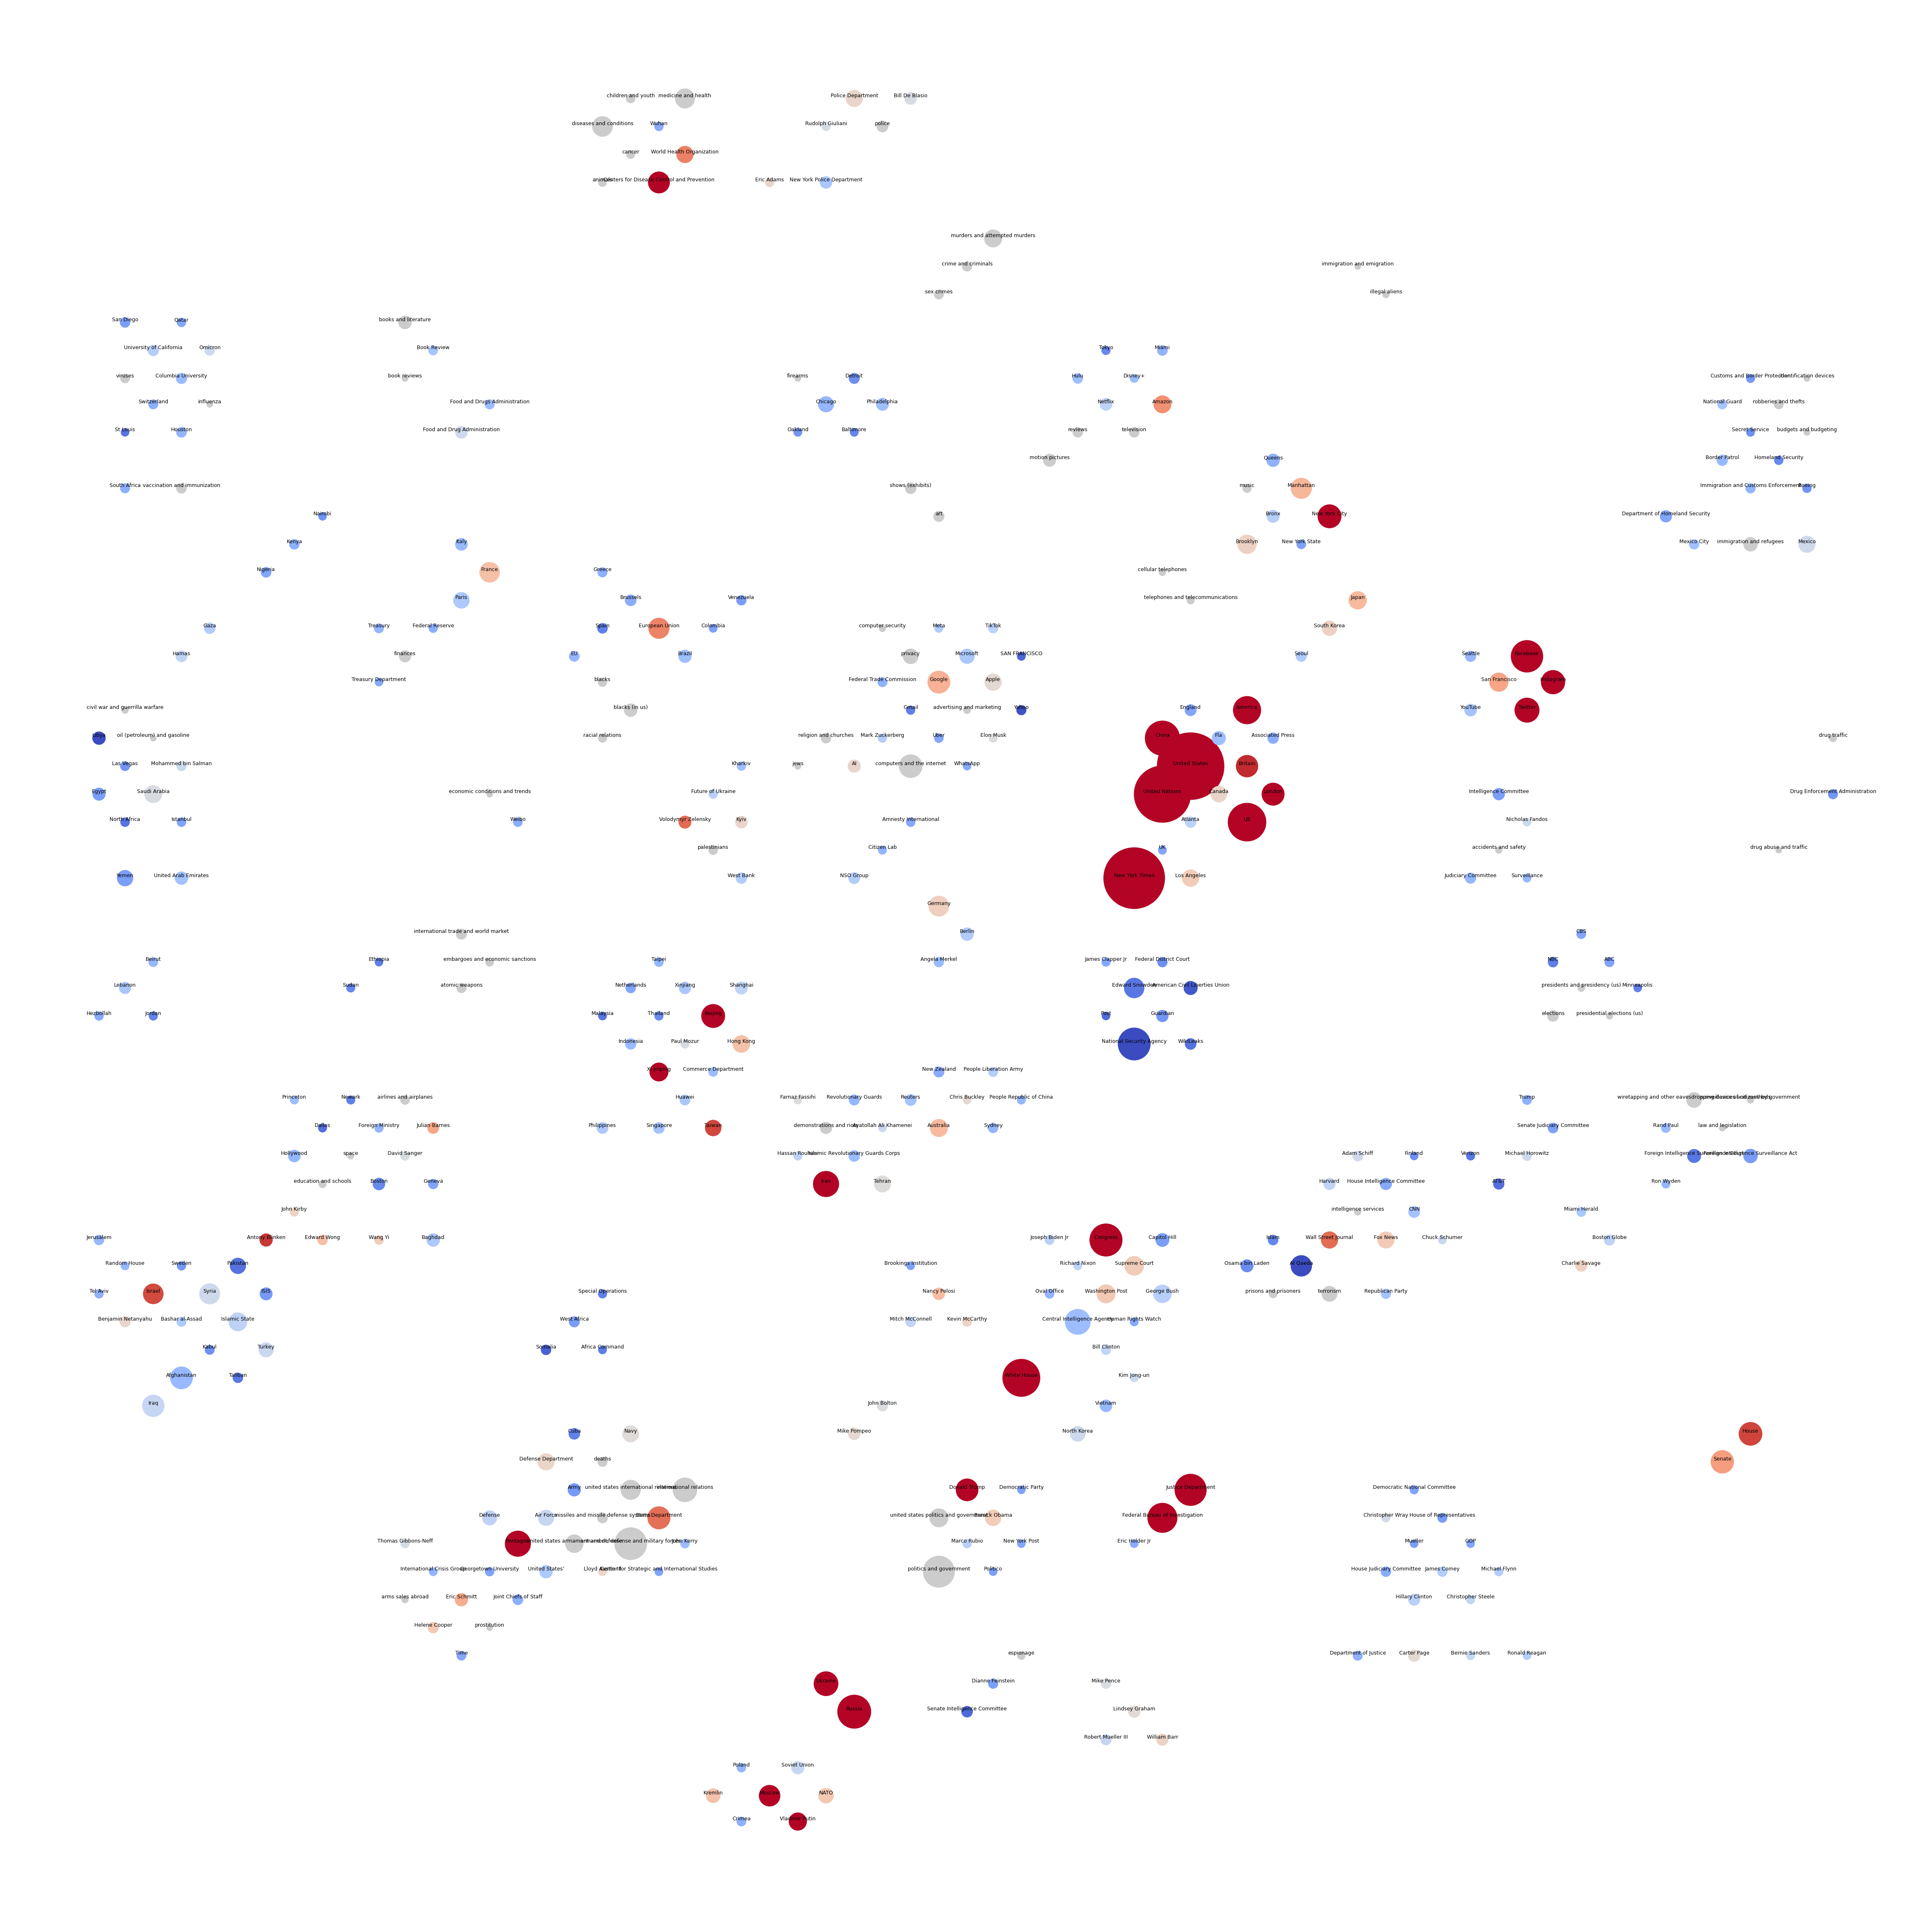

In [842]:
reducer = umap.UMAP(
    random_state=5,
    n_components=2,
    n_neighbors=2,
    min_dist=0.1,
    metric="hellinger",
)

embedding = reducer.fit_transform(train_data)  # Reducer
embedding = align_points_to_grid(embedding)  # Alignment to a grid

scaler = MinMaxScaler(feature_range=(100, 900))  # Scale
embedding = scaler.fit_transform(embedding)
embedding = embedding.astype(int)

index_embedding = 0  # Writing values in the dataset
for index, row in entities.iterrows():
    entities.loc[index, "x"] = embedding[:, 0][index_embedding]
    entities.loc[index, "y"] = embedding[:, 1][index_embedding]
    index_embedding += 1

# entities.sample(1)

plt.figure(figsize=(20, 20), dpi=300)
plt.axis("off")

# Scatterplot

plt.scatter(
    entities["x"].to_list(),
    entities["y"].to_list(),
    s=entities["frequency"].to_list(),
    c=entities["color"].to_list(),
)

# Labels

for i, row in entities.iterrows():
    text = plt.annotate(row["name"], xy=(row["x"], row["y"]), ha="center", va="bottom")
    text.set_fontsize(3)

plt.savefig("download.png")


## Clustering

In [843]:
clusterer = hdbscan.HDBSCAN(
    # min_samples=3,
    min_cluster_size=3,
    # cluster_selection_epsilon=50,   # float, optional (default=0.0) A distance threshold. Clusters below this value will be merged.
    # gen_min_span_tree=False,
    # leaf_size=5, # int, optional (default=40) If using a space tree algorithm (kdtree, or balltree) the number of points ina leaf node of the tree. This does not alter the resulting clustering, but may have an effect on the runtime of the algorithm.
)

entities["cluster"] = "-1"  # Reset


def cluster_computing(rows, prefix, entities):

    embedding = rows[["x", "y"]].to_numpy()
    clusterer.fit(embedding)
    clusters = clusterer.labels_

    # Write cluster number

    for count, (index, row) in enumerate(rows.iterrows()):
        if clusters[count] != -1:
            entities.loc[index, "cluster"] = prefix + str(clusters[count])
        else:
            entities.loc[index, "cluster"] = str(clusters[count])
    

cluster_computing(
    entities.loc[(entities["type"] != "tag") & (entities["slope"] > 0)],
    "p_",
    entities,
)
cluster_computing(
    entities.loc[(entities["type"] != "tag") & (entities["slope"] < 0)],
    "n_",
    entities,
)

entities.sample(1)

,name,type,frequency,slope,color,x,y,cluster,years,urls,titles,cooccurrences,frequency_norm,years_JSON
289,WikiLeaks,org,33,-0.817378,#5673e0,603,461,n_13,"{'2010': 0, '2011': 4, '2012': 0, '2013': 5, '...",[https://www.nytimes.com/2018/12/21/obituaries...,"[Timothy C. May, Early Advocate of Internet Pr...","[Corralitos, Santa Barbara, Santa Cruz County,...",0.021651,"{""2010"": 0, ""2011"": 4, ""2012"": 0, ""2013"": 5, ""..."


{'n_8', '-1', 'n_9', 'n_18', 'p_2', 'p_4', 'n_15', 'n_12', 'n_7', 'n_5', 'p_0', 'p_6', 'p_3', 'p_5', 'p_7', 'n_0', 'n_3', 'p_1', 'n_16', 'n_11', 'n_14', 'n_2', 'n_10', 'n_6', 'n_4', 'n_1', 'n_17', 'n_13'}
9
120
38
12
7
18
4
7
5
9
4
4
7
4
15
10
16
6
9
6
9
5
7
14
9
13
14
8


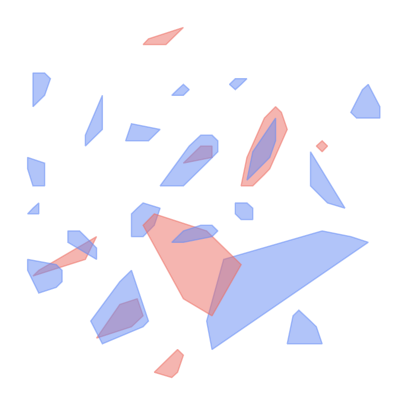

In [844]:
plt.figure(figsize=(5, 5))
plt.axis("off")

clusters = set(entities["cluster"].tolist())

print(clusters)

for counter, cluster in enumerate(clusters):

    points = []  # Points
    rows = entities.loc[entities["cluster"] == cluster]  # Rows

    for index, row in rows.iterrows():
        points.append([row["x"], row["y"]])
    points = np.array(points)

    print(len(points))

    hull = ConvexHull(points)  # Hull
    x_hull = np.append(points[hull.vertices, 0], points[hull.vertices, 0][0])
    y_hull = np.append(points[hull.vertices, 1], points[hull.vertices, 1][0])

    if cluster[0] == "p":
        plt.fill(x_hull, y_hull, "--", c="#ED6D62", alpha=0.5)  # Plot red
    elif cluster[0] == "n":
        plt.fill(x_hull, y_hull, "--", c="#648BF5", alpha=0.5)  # Plot blue


# Save

In [845]:
export = entities.copy()

export = export.drop(columns="years")
export = export.drop(columns="titles")
export = export.drop(columns="cooccurrences")


export.to_csv("src/data/entities.csv", index=False)

export.sample(1)


,name,type,frequency,slope,color,x,y,cluster,urls,frequency_norm,years_JSON
201,Paris,gpe,75,-0.317889,#adc9fd,267,667,n_11,[https://www.nytimes.com/2018/12/20/world/euro...,0.050068,"{""2010"": 1, ""2011"": 2, ""2012"": 1, ""2013"": 5, ""..."
